# Experimental Notebook

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

In [2]:
available_ts = []
for i in os.listdir('/media/gabriel/DATA/23/'):
    if i[11:19] not in available_ts:
        available_ts.append(i[11:19])

In [13]:
t = 2
print(f'Getting Videos for Time {available_ts[t]}')
vidcaps = []
for i in os.listdir('/media/gabriel/DATA/23/'):
    if i[11:19] == available_ts[t]:
        if i[20:25] in ['Cam48', 'Cam49', 'Cam50']:
            vidcaps.append(cv2.VideoCapture(f'/media/gabriel/DATA/23/{i}'))

Getting Videos for Time 00-40-00


[mov,mp4,m4a,3gp,3g2,mj2 @ 0xa6957c0] wrong sample count
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x3ee3dc0] wrong sample count
[mov,mp4,m4a,3gp,3g2,mj2 @ 0xc0a3040] wrong sample count


In [141]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(f'{available_ts[t]}_stitched.mp4', fourcc, 30.0, (2869, 1946))

for i in tqdm.trange(10800, 12000):
    current_frame = []
    for vidcap in vidcaps:
        __, frame = vidcap.read()
        current_frame.append(frame)
        
    img0 = current_frame[0].transpose((1,0,2))
    img1 = current_frame[1].transpose((1,0,2))
    img2 = current_frame[2].transpose((1,0,2))   
    
    canvas = np.zeros((1946, 2869, 3)).astype(np.uint8)
    
    im2 = cv2.resize(img2, (1055, 1876))
    im2 = rotate_image(im2, -0.51)
    canvas[51:51+im2.shape[0], 0:0+im2.shape[1], :] = im2

    im0 = cv2.resize(img0, (1058, 1881))
    im0 = rotate_image(im0, -0.14)
    canvas[0:0+im0.shape[0], 1805:1805+im0.shape[1], :] = im0

    ff = canvas[26:26+img1.shape[0], 973:973+img1.shape[1], :] == 0
    ff = expand(ff, 2)
    canvas[26:26+img1.shape[0], 973:973+img1.shape[1], :][ff] = img1[ff]
    out.write(canvas)
    
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/1200 [00:00<?, ?it/s]

In [142]:
out.release()

In [143]:
frame_no = 10800
current_frame = []
for vidcap in vidcaps:
    vidcap.set(1,frame_no)
    __, frame = vidcap.read()
    current_frame.append(frame)
current_frame = np.ascontiguousarray(current_frame)

In [144]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter(f'{available_ts[t]}.mp4', fourcc, 30.0, (3240, 1920))

for i in tqdm.trange(10800, 12000):
    current_frame = []
    for vidcap in vidcaps:
        __, frame = vidcap.read()
        current_frame.append(frame)
    current_frame = np.ascontiguousarray(np.concatenate(np.array(current_frame[::-1]).transpose(0,2,1,3), axis = 1))
    out.write(current_frame)
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/1200 [00:00<?, ?it/s]

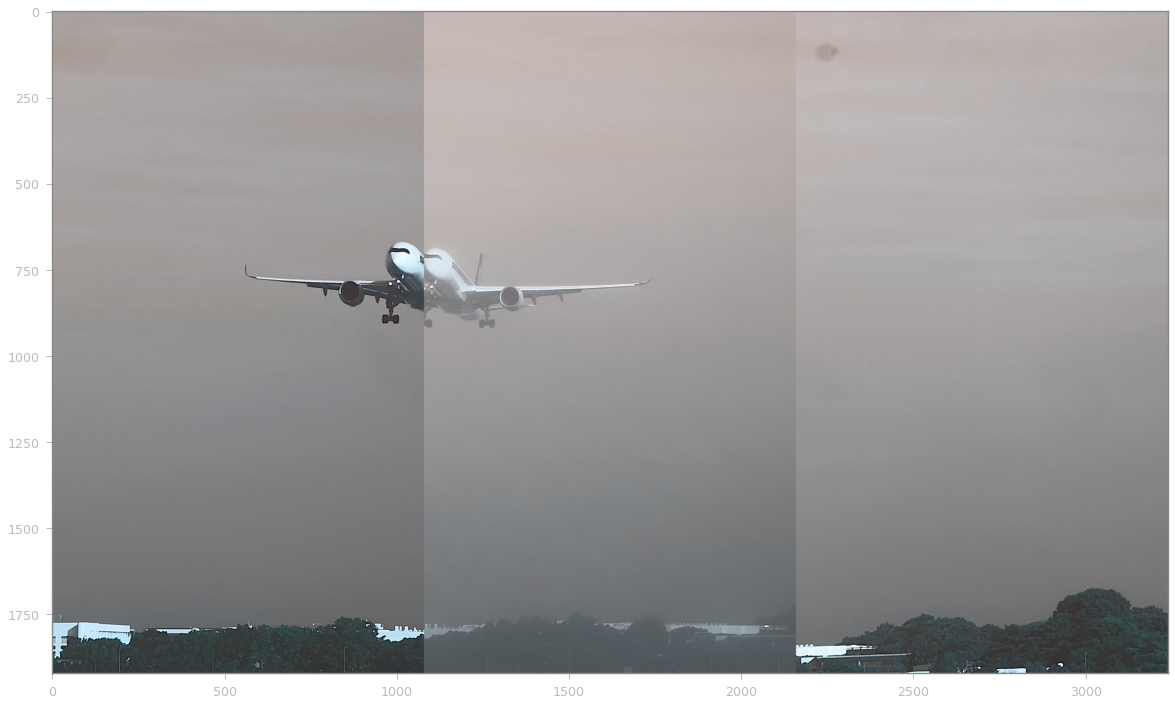

In [102]:
plt.figure(figsize = (20,20))
img0 = current_frame[0].transpose((1,0,2))
img1 = current_frame[1].transpose((1,0,2))
img2 = current_frame[2].transpose((1,0,2))
plt.imshow(np.concatenate((current_frame[::-1]).transpose(0,2,1,3), axis = 1))

In [103]:
from PIL import Image
im = Image.fromarray(np.concatenate((current_frame[::-1]).transpose(0,2,1,3), axis = 1))
im.save("2_calibration.png")

In [92]:
def rotate_image(image, angle):
    image = np.pad(image, ((100,100),(100,100),(0,0)), 'constant', constant_values=0)
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    horizontal_filter = np.logical_not(np.all(result[:, :, 0] == 0, axis = 0))
    vertical_filter = np.logical_not(np.all(result[:, :, 0] == 0, axis = 1))
    return result[vertical_filter][:, horizontal_filter]

def expand(selection, radius):
    cop = np.copy(selection)
    for x in range(-radius,radius+1):
        for y in range(-radius,radius+1):
            if (y==0 and x==0) or (x**2 + y**2 > radius **2):
                continue
            shift = np.roll(np.roll(selection, y, axis = 0), x, axis = 1)
            cop += shift
    return cop


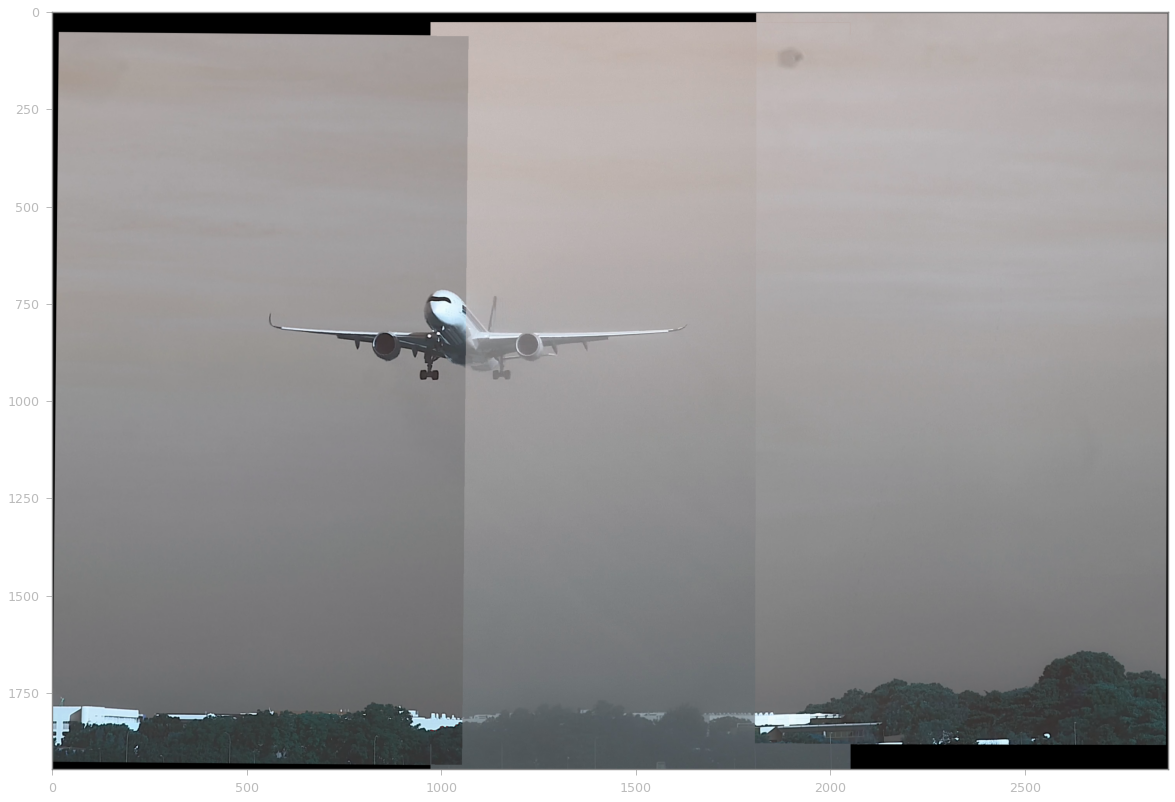

In [132]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
canvas = np.zeros((1946, 2869, 3)).astype(np.uint8)

im2 = cv2.resize(img2, (1055, 1876))
im2 = rotate_image(im2, -0.51)
canvas[51:51+im2.shape[0], 0:0+im2.shape[1], :] = im2

im0 = cv2.resize(img0, (1058, 1881))
im0 = rotate_image(im0, -0.14)
canvas[0:0+im0.shape[0], 1805:1805+im0.shape[1], :] = im0

ff = canvas[26:26+img1.shape[0], 973:973+img1.shape[1], :] == 0
ff = expand(ff, 2)
canvas[26:26+img1.shape[0], 973:973+img1.shape[1], :][ff] = img1[ff]

ax.imshow(canvas)